In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-cats-images/dataset/test_set/dogs/dog.4329.jpg
/kaggle/input/dogs-cats-images/dataset/test_set/dogs/dog.4223.jpg
/kaggle/input/dogs-cats-images/dataset/test_set/dogs/dog.4253.jpg
/kaggle/input/dogs-cats-images/dataset/test_set/dogs/dog.4190.jpg
/kaggle/input/dogs-cats-images/dataset/test_set/dogs/dog.4354.jpg
/kaggle/input/dogs-cats-images/dataset/test_set/dogs/dog.4136.jpg
/kaggle/input/dogs-cats-images/dataset/test_set/dogs/dog.4226.jpg
/kaggle/input/dogs-cats-images/dataset/test_set/dogs/dog.4214.jpg
/kaggle/input/dogs-cats-images/dataset/test_set/dogs/dog.4888.jpg
/kaggle/input/dogs-cats-images/dataset/test_set/dogs/dog.4170.jpg
/kaggle/input/dogs-cats-images/dataset/test_set/dogs/dog.4323.jpg
/kaggle/input/dogs-cats-images/dataset/test_set/dogs/dog.4262.jpg
/kaggle/input/dogs-cats-images/dataset/test_set/dogs/dog.4788.jpg
/kaggle/input/dogs-cats-images/dataset/test_set/dogs/dog.4657.jpg
/kaggle/input/dogs-cats-images/dataset/test_set/dogs/dog.4387.jpg
/kaggle/in

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import glob as gb
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
import imagehash
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout

from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.applications import DenseNet121

In [3]:
train_path = '../input/dogs-cats-images/dog vs cat/dataset/training_set'
test_path = '../input/dogs-cats-images/dog vs cat/dataset/test_set'

In [4]:
train_datagen = ImageDataGenerator(
    rescale = 1.0/255,  # rescale pixel values to [0,1]
    rotation_range = 20,  # random rotation within 20 degrees
    width_shift_range = 0.2, # random horizontal shift by 20% of image width
    height_shift_range = 0.2, # random vertical shift by 20% of image height
    horizontal_flip = True , # random horizontal flipping
    
    fill_mode = 'nearest' # fill mode for new pixels after shift/rotations
    
)

In [5]:
size_images = 200
batch_size = 64

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_path,  # path to the training data
    target_size = (size_images,size_images), # resize the images to this size
    batch_size = batch_size, # number of images in each batcj
    seed = 32, # optional : set a random seed for shuffling images
    shuffle = True, 
    class_mode = 'categorical' # Mode for class labels (categorical for one-hot encoding)
    
)

Found 8000 images belonging to 2 classes.


## bar chart to display the number of images per class

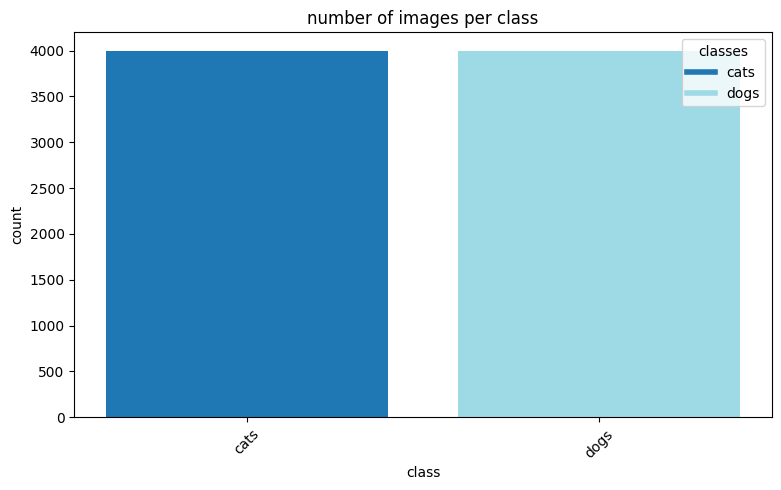

In [7]:
# get class labels and indices
class_labels = list(train_generator.class_indices.keys())

# calculate the count of images per class
class_counts = {label: train_generator.labels.tolist().count(train_generator.class_indices[label]) for label in class_labels}

# define unique colors for each class 
class_colors = plt.cm.tab20(np.linspace(0,1,len(class_labels)))

# create a bar chart with different colors for each class

plt.figure(figsize=(9,5))
plt.bar(class_counts.keys(),class_counts.values(),color = class_colors)

plt.xlabel('class')
plt.ylabel('count')
plt.title('number of images per class')
plt.xticks(rotation=45)

# add legend for class colors
legend_labels = [plt.Line2D([0],[0],color = class_colors[i], lw=4,label = class_labels[i])for i in range(len(class_labels))]
plt.legend(handles=legend_labels,title='classes')
plt.show()

In [8]:
test_datagen = ImageDataGenerator(rescale = 1.0/255) # rescaling the image [0,1]

In [9]:
test_generator =  test_datagen.flow_from_directory(
    test_path,
    target_size = (size_images,size_images),
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 2000 images belonging to 2 classes.


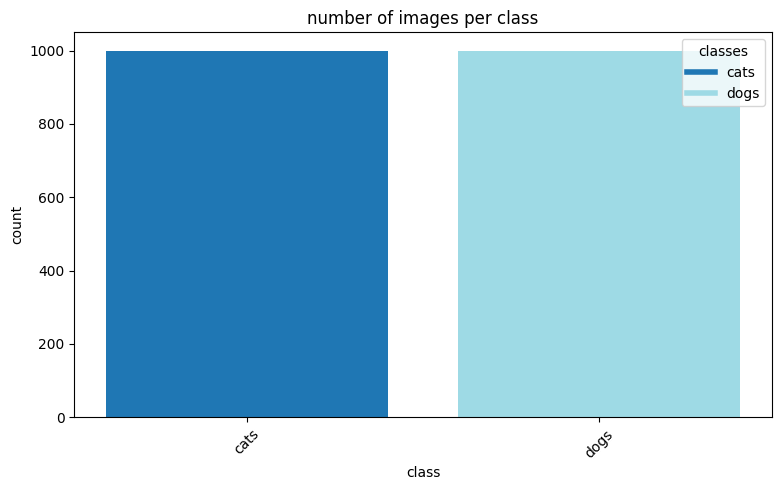

In [10]:
# get class labels and indices
class_labels = list(test_generator.class_indices.keys())

# calculate the count of images per class
class_counts = {label: test_generator.labels.tolist().count(test_generator.class_indices[label]) for label in class_labels}

# define unique colors for each class 
class_colors = plt.cm.tab20(np.linspace(0,1,len(class_labels)))

# create a bar chart with different colors for each class

plt.figure(figsize=(9,5))
plt.bar(class_counts.keys(),class_counts.values(),color = class_colors)

plt.xlabel('class')
plt.ylabel('count')
plt.title('number of images per class')
plt.xticks(rotation=45)

# add legend for class colors
legend_labels = [plt.Line2D([0],[0],color = class_colors[i], lw=4,label = class_labels[i])for i in range(len(class_labels))]
plt.legend(handles=legend_labels,title='classes')
plt.show()

# model creation

In [11]:
base_model = DenseNet121(weights='imagenet',include_top=False,input_shape = (size_images,size_images,3))

29084464/29084464 [==============================] - 2s 0us/step


## freeze the layers of DenseNet121

In [12]:
for layer in base_model.layers :
    layer.trainable = False

In [13]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(256,activation='relu'),
    Dense(128,activation='relu'),
    Dropout(0.4),
    Dense(64,activation='relu'),
    Dropout(0.5),
    Dense(2,activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 6, 6, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 36864)             0         
                                                                 
 dense (Dense)               (None, 256)               9437440   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [14]:
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics=['accuracy'])

In [15]:
history = model.fit(train_generator,epochs=3,steps_per_epoch = train_generator.samples//batch_size,validation_data = test_generator,validation_steps = test_generator.samples//batch_size)

Epoch 1/3
125/125 [==============================] - 735s 6s/step - loss: 0.4852 - accuracy: 0.9153 - val_loss: 0.0600 - val_accuracy: 0.9849
Epoch 2/3
125/125 [==============================] - 724s 6s/step - loss: 0.1374 - accuracy: 0.9571 - val_loss: 0.0500 - val_accuracy: 0.9874
Epoch 3/3
125/125 [==============================] - 729s 6s/step - loss: 0.1138 - accuracy: 0.9630 - val_loss: 0.0653 - val_accuracy: 0.9869


In [16]:
# Evaluate on test dataset
score = model.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.06491798162460327
Test accuracy: 0.9869999885559082


<Figure size 640x480 with 0 Axes>

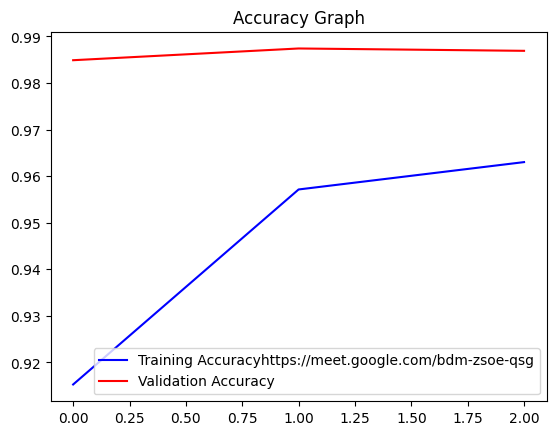

<Figure size 640x480 with 0 Axes>

In [17]:
# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracyhttps://meet.google.com/bdm-zsoe-qsg')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

32/32 [==============================] - 138s 4s/step


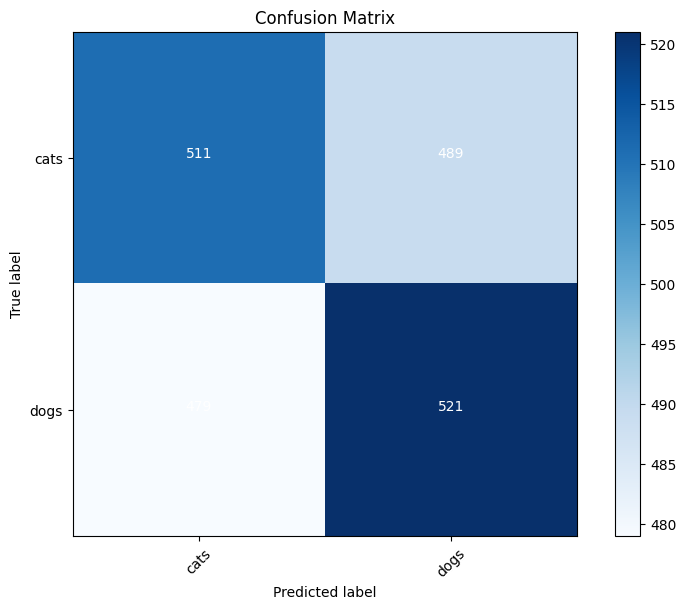

32/32 [==============================] - 137s 4s/step


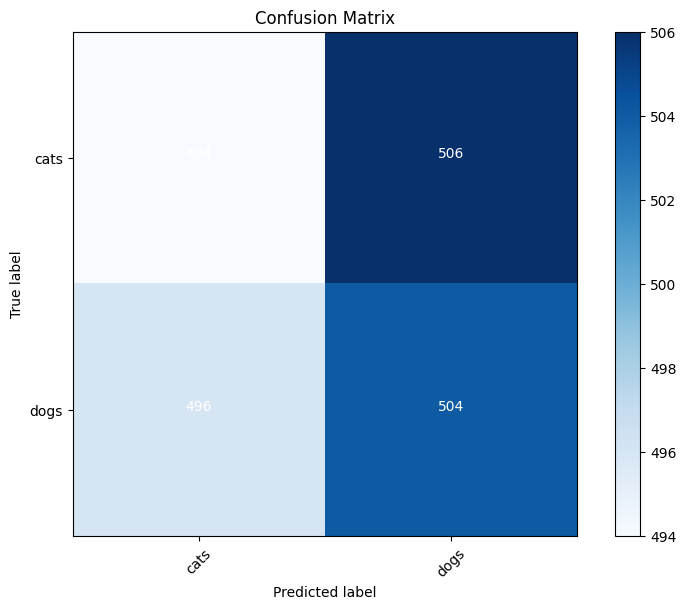

In [18]:
# Confusion Matrix
import itertools

# Make predictions on the test data
predictions = model.predict(test_generator)

# Convert probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels from the test_generator
true_labels = test_generator.classes

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define class names (assuming you have class_names defined)
class_names = test_generator.class_indices.keys()

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes=class_names, title="Confusion Matrix")
plt.show()# Confusion Matrix
import itertools

# Make predictions on the test data
predictions = model.predict(test_generator)

# Convert probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels from the test_generator
true_labels = test_generator.classes

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define class names (assuming you have class_names defined)
class_names = test_generator.class_indices.keys()

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes=class_names, title="Confusion Matrix")
plt.show()